## Unsupervised Anomaly Detection With NASA Shuttles

Inside `shuttle.csv` there is data collected from NASA shuttles. The first nine columns are various readings from the shuttle, while the last column shows whether the data point is an anomaly or not. Because we are using unsupervised methods the last column will only be used to judge performance. 

Your task is threefold:

1. Determine the proper number of clusters in the data using techniques discussed in class.
2. Fit a clustering method to the data and determine the proper threshold for anomaly detection.
3. Classify your data and report the relevant performance metric.

Put together a quick 5 minute technical presentation (Target audience: Fellow Data Scientists) explaining your methods, decisions, and results.

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
import sklearn.metrics.pairwise
import scipy.spatial.distance
from sklearn.model_selection import train_test_split



In [0]:
data = pd.read_csv('Ashish Piya - shuttle.csv',header=0 )#,dtype=np.float32)



In [54]:

data.head(5)

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,y
0,50,21,77,0,28,0,27,48,22,1
1,53,0,82,0,52,-5,29,30,2,0
2,37,0,76,0,28,18,40,48,8,0
3,37,0,79,0,34,-26,43,46,2,0
4,85,0,88,-4,6,1,3,83,80,1


In [55]:
data = data.to_numpy()
data = data.astype('float32')
print(data.dtype)


y = data[:,-1]
x = data[:,:-1]

print(x.shape)
print(y.shape)

float32
(49097, 9)
(49097,)


In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [0]:
x = x_train
y = y_train

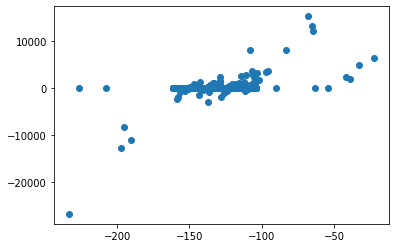

In [59]:
def PCA(x, dims):
    #this makes it symmetric
    x_sym = x.T @ x
    eigen_values,  eigen_vectors = np.linalg.eig(x_sym)
    x_transformed = x @ eigen_vectors[:, np.argsort(eigen_values)[-dims:]]  #np.argsort(eigen_values) sorts the eigen values and [-dims:] gives it from larfgest to smallest
    return x_transformed

x_transformed = PCA(x, 2)  #dims = 2    # here we have reduced the dimensionality of value from 9 to 2 by PCA
plt.scatter(x_transformed[:,0], x_transformed[:,1])


In [0]:
def var(x):
    return np.sum((x - np.mean(x, axis = 0)) ** 2 ) / x.shape[0]

def DistAll(x):
    dists = np.zeros([len(x), len(x)], dtype = 'float32')
    for i in range(len(x)):
        dists[:,i] = np.sum((x - x[i]) ** 2, axis = 1)
    return dists    

def Responsibility(x, centroid, beta):
    diff = x - centroid
    dist = np.sum(diff ** 2, axis=1)
    return np.exp(-beta * dist) / np.sum(np.exp(-beta * dist))

def Dist(x, centroid):
    diff = x - centroid
    return np.sum(diff ** 2, axis=1)


class Clustering:
    def DBI(self, x):
        y_hat = self.Predict(x)
        k = self.k
        variances = []
        for i in range(k):
             variances.append(var(x[y_hat == i]))
        variances = np.hstack(variances)
        out = 0
        for i in range(k):
            out += np.max((np.delete(variances, i, axis=0) + variances[i]) / 
                   np.sum((np.delete(self.centroids, i, axis=0) - self.centroids[i]) ** 2, axis=1))

        return out / k
    
    def CHI(self, x):
        y_hat = self.Predict(x)
        n = len(y_hat)
        denom = 0
        num = 0
        for k in range(self.k):
            n_k = np.sum(y_hat == k)
            m_k = self.centroids[k]
            m = np.mean(x, axis = 0)
            denom += np.sum((x[y_hat == k] - m_k) ** 2)
            num += n_k * np.sum((m_k - m) ** 2)
        return (num / denom) * (n - self.k) / (self.k - 1)
                
    
    def Silhouette(self, x):
        y_hat = self.Predict(x)
        b = np.zeros(y_hat.shape)
        a = np.zeros(y_hat.shape)
        
        for k in range(self.k):
            cluster = y_hat == k
            
            dist = DistAll(x[cluster])
            
            b[cluster] = np.mean(dist, axis=1)
            
            for j in range(self.k):
                if j != k:
                    a[cluster] += np.sum((x[cluster] - self.centroids[j]) ** 2, axis = 1)
        
        a /= self.k-1
        
        return (a-b) / np.max(np.vstack([b, a]), axis=0)
    
    def SilhouettePlot(self, x):
        y_hat = self.Predict(x)
        sil = self.Silhouette(x)
        sil_out = []
        y_hat_out = []
        for i in range(self.k):
            sil_cluster = sil[y_hat == i]
            y_hat_cluster = y_hat[y_hat == i]

            ind = np.argsort(sil_cluster)[::-1]

            sil_out.append(sil_cluster[ind])
            y_hat_out.append(y_hat_cluster[ind])

        sil_out = np.hstack(sil_out)
        y_hat_out = np.hstack(y_hat_out)
        plt.scatter(np.arange(sil_out.shape[0]), sil_out, c = y_hat_out, cmap='jet')
        plt.title('k = {}'.format(self.k))
        plt.show()


def var(x):
    return np.sum((x - np.mean(x, axis = 0)) ** 2 ) / x.shape[0]

class SoftKMeans(Clustering):
    def __init__(self, k, beta):
        self.k = k
        self.beta = beta
        
    def Fit(self, x, iterations = 10):
        # Step 1
        self.centroids = x[np.random.choice(np.arange(x.shape[0]), size=self.k)]
        for i in range(iterations):
            print('\rIterations: {} '.format(i), end='')
            # Step 2
            diffs = np.stack([x] * self.k) - self.centroids.reshape(self.k, 1, x.shape[1])
            dist = np.sum(diffs ** 2, axis = 2)
            resp = np.exp(-self.beta * dist) / np.sum(np.exp(-self.beta * dist), axis = 1, keepdims=True)
            # Step 3
            y_hat = np.argmax(resp, axis = 0)
            # Step 4
            old_centroids = self.centroids.copy()
            for i in range(self.k):
                resp_i = resp[i, y_hat==i].reshape(-1, 1)
                self.centroids[i, :] = np.sum(x[y_hat==i] * resp_i, axis=0) / (np.sum(resp_i) + 1e-99)
#             print(np.sum((old_centroids - self.centroids) ** 2))
            if (np.sum((old_centroids - self.centroids) ** 2)) < 1e-15:
                break
            
        return self.centroids
    
    def Predict(self, x):
        # Step 2
        diffs = np.stack([x] * self.k) - self.centroids.reshape(self.k, 1, x.shape[1])
        dist = np.sum(diffs ** 2, axis = 2)
        resp = np.exp(-self.beta * dist) / np.sum(np.exp(-self.beta * dist), axis = 1, keepdims=True)
        # Step 3
        y_hat = np.argmax(resp, axis = 0)
        
        return y_hat
    
class KMeans(Clustering):
    def __init__(self, k):
        self.k = k
        
    def Fit(self, x, iterations = 10):
        # Step 1
        self.centroids = x[np.random.choice(np.arange(x.shape[0]), size=self.k)]
        for i in range(iterations):
            print('\rIterations: {}'.format(i), end='')
            # Step 2
            diffs = np.stack([x] * self.k) - self.centroids.reshape(self.k, 1, x.shape[1])
            dist = np.sum(diffs ** 2, axis = 2)
            # Step 3
            y_hat = np.argmin(dist, axis = 0)
            # Step 4
            old_centroids = self.centroids.copy()
            for i in range(self.k):
                self.centroids[i, :] = np.mean(x[y_hat==i], axis=0)
            if (np.sum((old_centroids - self.centroids) ** 2)) < 1e-15:
                break
            
        return self.centroids
    
    def Predict(self, x):
        diffs = np.stack([x] * self.k) - self.centroids.reshape(self.k, 1, x.shape[1])
        dist = np.sum(diffs ** 2, axis = 2)
        # Step 3
        y_hat = np.argmin(dist, axis = 0)
        
        return y_hat  

In [0]:
class GMM(Clustering):
    def __init__(self, k):
        self.k = k
        
        
    def Fit(self, x, iterations = 10):
        
        self.centroids = x[np.random.choice(np.arange(x.shape[0]), size = self.k)]
        self.covs  = [np.eye(x.shape[1])] * self.k
        
        for i in range(iterations):      
            y_hat = self.Predict(x)
            old_centroid = self.centroids.copy()

            for k in range(self.k):
                self.centroids[k, :] = np.mean(x[y_hat == k], axis = 0)
                self.covs[k] = np.cov(x[y_hat == k].T )
                
            if np.sum((old_centroid == self.centroids)) < 1e-15:
                    break     
                
    def Predict(self, x):
        probs = self.Probabilities(x)
        y_hat = np.argmax(probs, axis = 0)
        return y_hat
    
    def Probabilities(self, x):
        probs = []
        for k in range(self.k):
            probs.append(mvn.pdf(x,mean = self.centroids[k], cov = self.covs[k], allow_singular = True))
        probs = np.vstack(probs)
        return probs
    
    def Loss(self, x):
        probs = self.Probabilities(x)
        y_hat = self.Predict(x)
        unique, counts = np.unique(y_hat, return_counts = True)
        pis = counts.reshape(-1,1)/ (y_hat.shape[0] + 1e-99)
        
        return -np.sum(np.log(np.sum(probs*pis, axis = 0)))
                    

In [0]:
class DBSCAN():
    def __init__(self, core_thresh, neighbor_thresh):
            
            self.core_thresh = core_thresh
            self.neighbor_thresh = neighbor_thresh
            
            
    def Fit(self, x):        
    
    
#         def DistAll(x):
#         diff = x.reshape(1, x.shape[0], x.shape[1]) - x.reshape(x.shape[0],1, x.shape[1])
#         dist = np.sum(diff **2, axis = 2)
#         return dist
#         dists = DistAll(x)

        dists = np.sum((x.reshape(1, -1, x.shape[1]) - x.reshape(-1, 1, x.shape[1]))**2, axis= 2)

        neighbors = dists < self.neighbor_thresh
        neighbor_count = np.sum(neighbors, axis = 0)

        core = neighbor_count > self.core_thresh
        avail = core.copy() # copy cores
        clusters = []
        
        while avail.any():
            ind = np.random.choice(np.where(avail)[0]) # we put [0] to not get tuple

            cluster = neighbors[ind]
            old_cluster = np.zeros(cluster.shape)

            while np.any(cluster != old_cluster):
                old_cluster = cluster.copy()
                cluster = np.any(cluster | neighbors[cluster & core], axis = 0)
                
            avail = avail & ~cluster # ~cluster means not cluster
            clusters.append(cluster)

        y_hat = np.vstack(clusters)

        noise = ~np.any(y_hat, axis = 0)

        y_hat = np.vstack([ noise, y_hat])
        
        self.core_points = x[core]
        self.core_class = np.argmax(y_hat, axis = 0)[core]
    
    def Predict(self,x):
        dists = np.sum((x.reshape(1, -1, x.shape[1]) - self.core_points.reshape(-1, 1, x.shape[1]))**2, axis = 2)
        y_hat = self.core_class[np.argmin(dists, axis = 0)]
        neighbors = dists < self.neighbor_thresh
        y_hat[~np.any(neighbors)]=0
        return y_hat
        
#         neighbors_class = neighbors * self.core_class
#         unique, counts = np.unique(neighbors_class, return_counts=True, axis = 1)
#         return counts
        

Iterations: 9

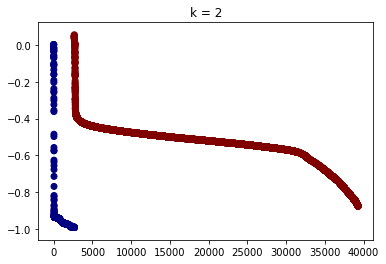

In [64]:
for i in range(2, 3):
    kmeans = KMeans(i)
    centroids = kmeans.Fit(x)
    y_hat = kmeans.Predict(x)
    kmeans.SilhouettePlot(x)
        

Iterations: 9

Text(0.5, 1.0, 'Davies-Bouldin Index')

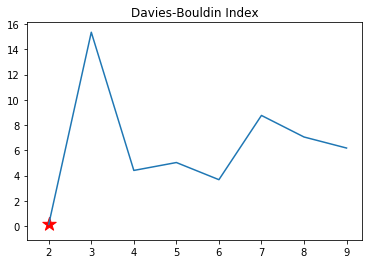

In [80]:
dbis = []
ks = list(range(2,10))
tries = 15
for k in ks:
    dbi = []
    for i in range(tries):
        
        kmeans = KMeans(k)
        kmeans.Fit(x,10)
        db_temp = kmeans.DBI(x)
        if not np.isnan(db_temp):
            dbi.append(db_temp)
    dbis.append(np.min(dbi))
 
dbi_min = np.argmin(dbis)
plt.plot(ks, dbis)
plt.scatter(dbi_min+2, dbis[dbi_min], c='r',marker='*', s = 200 )
plt.xticks(ks);
plt.title('Davies-Bouldin Index')


Iterations: 4

Text(0.5, 1.0, 'Calinski-Haribasz Index')

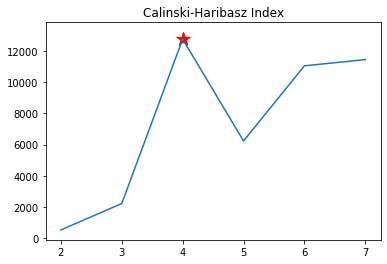

In [81]:
chis = []
ks = list(range(2,8))
tries = 15

for k in ks:
    chi = []
    for i in range(tries):
        kmeans = KMeans(k)
        kmeans.Fit(x, 5)
        chi_temp = kmeans.CHI(x)
        if not np.isnan(chi_temp):
            chi.append(chi_temp)
    chis.append(np.max(chi))

chi_max = np.argmax(chis)

plt.plot(ks, chis)

plt.scatter(chi_max+2, chis[chi_max], c='r', marker ='*', s = 200)
plt.xticks(ks);
plt.title('Calinski-Haribasz Index')


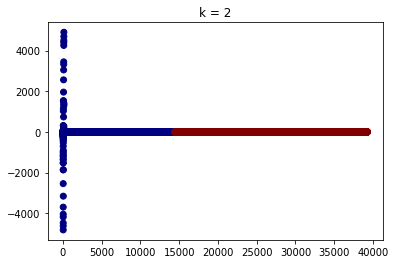

In [67]:
gmm = GMM(2)
gmm.Fit(x)
y_hat = gmm.Predict(x)
plt.scatter(x[:,0], x[:,1], c=y_hat, cmap ='jet')
gmm.SilhouettePlot(x)

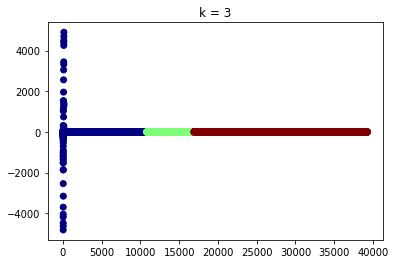

In [82]:
gmm = GMM(3)
gmm.Fit(x)
y_hat = gmm.Predict(x)
plt.scatter(x[:,0], x[:,1], c=y_hat, cmap ='jet')
gmm.SilhouettePlot(x)

Text(0.5, 1.0, 'Davies-Bouldin Index')

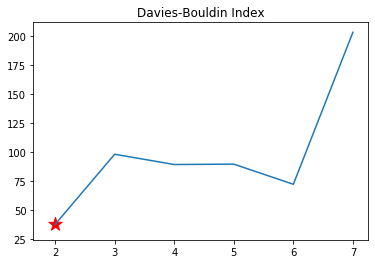

In [68]:
dbis = []
ks = list(range(2,8))
tries = 10
for k in ks:
    dbi = []
    for i in range(tries):
        
        gmm = GMM(k)
        gmm.Fit(x,10)
        db_temp = gmm.DBI(x)
        if not np.isnan(db_temp):
            dbi.append(db_temp)
    dbis.append(np.min(dbi))
 
dbi_min = np.argmin(dbis)
plt.plot(ks, dbis)
plt.scatter(dbi_min+2, dbis[dbi_min], c='r',marker='*', s = 200 )
plt.xticks(ks);
plt.title('Davies-Bouldin Index')


Text(0.5, 1.0, 'Calinski-Haribasz Index')

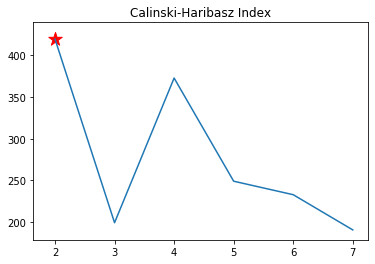

In [78]:
chis = []
ks = list(range(2,8))
tries = 12

for k in ks:
    chi = []
    for i in range(tries):
        gmm = GMM(k)
        gmm.Fit(x, 10)
        chi_temp = gmm.CHI(x)
        if not np.isnan(chi_temp):
            chi.append(chi_temp)
        else: pass    
    chis.append(np.max(chi))

chi_max = np.argmax(chis)

plt.plot(ks, chis)

plt.scatter(chi_max+2, chis[chi_max], c='r', marker ='*', s = 200)
plt.xticks(ks);
plt.title('Calinski-Haribasz Index')


In [0]:
#Train Data

In [87]:
kmeans = SoftKMeans(2, beta = 20)
centroids = kmeans.Fit(x, 10)
y_hat = kmeans.Predict(x)
#kmeans.SilhouettePlot(x)
#plt.scatter(x[:,0],x[:,1], c = kmeans.Predict(x), cmap = 'jet')
#plt.scatter(centroids[:,0], centroids[:,1], c='k')

Iterations: 0 

In [88]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

#target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y, y_hat))#, target_names=target_names))

print(roc_auc_score(y, y_hat))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     36486
         1.0       0.00      0.00      0.00      2791

    accuracy                           0.93     39277
   macro avg       0.46      0.50      0.48     39277
weighted avg       0.86      0.93      0.89     39277

0.4999040727950447


In [0]:
# import scikitplot as skplt
# import matplotlib.pyplot as plt
# skplt.metrics.plot_roc_curve(y, y_hat)
# plt.show()

In [0]:
p = y_hat

In [90]:
TP = sum((p == y) ==1)
print('True Positives: {} '.format(TP))

TN = sum((p == y) == 0)
print('True Negatives: {} '.format(TN))

FP = sum((p == 1) & (y == 0))  #FP = sum((p_hat == 1) * (y == 0))
print('False Positives: {} '.format(FP))

FN = sum((p == 0) & (y == 1))
print('False Negatives: {} '.format(FN))

Accuracy = (TP + TN)/(TP + TN + FP + FN)
print('Accuracy: {} '.format(Accuracy))


Precision = (TP)/(TP + FP)
print('Precision: {} '.format(Precision))


Recall = (TP)/(TP + FN)
print('Recall: {} '.format(Recall))


F1_score = (2*Precision*Recall)/(Precision + Recall)
print('F1_score: {} '.format(F1_score))



TPR =(TP)/(TP + FN)
print('True Positive Rate: {} '.format(TPR))


FPR = (FP)/(FP + TN)
print('False Positive Rate: {} '.format(FPR))




True Positives: 36479 
True Negatives: 2798 
False Positives: 7 
False Negatives: 2791 
Accuracy: 0.9334997029114677 
Precision: 0.9998081455900893 
Recall: 0.9289279348102878 
F1_score: 0.9630656317651407 
True Positive Rate: 0.9289279348102878 
False Positive Rate: 0.0024955436720142605 


In [91]:
def accuracy(y, y_hat):
    return np.mean(y == y_hat)
print(f"Accuracy: {accuracy(y, y_hat):0.3f}")

Accuracy: 0.929


In [92]:
#Test Data
kmeans = SoftKMeans(2, beta = 20)
centroids = kmeans.Fit(x, 10)
y_hat = kmeans.Predict(x_test)


Iterations: 0 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide


In [0]:
p = y_hat
y = y_test

In [95]:
TP = sum((p == y) ==1)
print('True Positives: {} '.format(TP))

TN = sum((p == y) == 0)
print('True Negatives: {} '.format(TN))

FP = sum((p == 1) & (y == 0))  #FP = sum((p_hat == 1) * (y == 0))
print('False Positives: {} '.format(FP))

FN = sum((p == 0) & (y == 1))
print('False Negatives: {} '.format(FN))

Accuracy = (TP + TN)/(TP + TN + FP + FN)
print('Accuracy: {} '.format(Accuracy))


Precision = (TP)/(TP + FP)
print('Precision: {} '.format(Precision))


Recall = (TP)/(TP + FN)
print('Recall: {} '.format(Recall))


F1_score = (2*Precision*Recall)/(Precision + Recall)
print('F1_score: {} '.format(F1_score))



TPR =(TP)/(TP + FN)
print('True Positive Rate: {} '.format(TPR))


FPR = (FP)/(FP + TN)
print('False Positive Rate: {} '.format(FPR))




True Positives: 9100 
True Negatives: 720 
False Positives: 0 
False Negatives: 720 
Accuracy: 0.9316888045540797 
Precision: 1.0 
Recall: 0.9266802443991853 
F1_score: 0.9619450317124736 
True Positive Rate: 0.9266802443991853 
False Positive Rate: 0.0 
